In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize 


btc = pd.read_excel("../data/processed/btcusd_20200510_20230310.xlsx")

avg_timeframe = 50

In [ ]:
btc[0:1]

,Datetime,value
0,2020-05-10,8761.299747
1,2020-05-11,8599.781947
2,2020-05-12,8800.729722
3,2020-05-13,9274.856203
4,2020-05-14,9742.732853
...,...,...
1025,2023-03-01,23652.749774
1026,2023-03-02,23479.321887
1027,2023-03-03,22359.217210
1028,2023-03-04,22347.343924


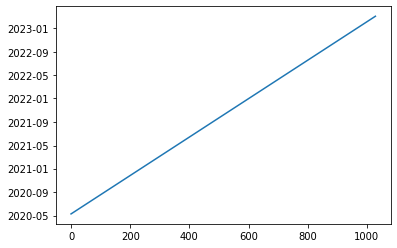

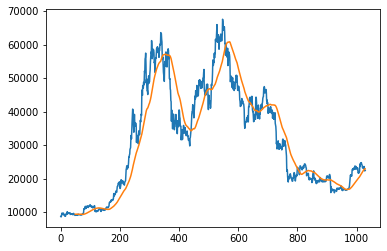

In [99]:
#Check Data Quality


plt.plot(btc.Datetime)
plt.show()


btc["MA"] = btc.value.rolling(window = avg_timeframe).mean()
plt.plot(btc.value)
plt.plot(btc.MA)
plt.show()

In [100]:
btc["Chg_btc"] = btc.value.pct_change()


def positionlabel(row):
    if row["value"]> row["MA"]:
        return 1
    elif row["value"] == row["MA"]:
        return 0
    else:
        return -1

btc["Position"] = btc.apply(lambda row: positionlabel(row), axis = 1)
btc["DailyPnL"]= btc["Position"].shift(1)*btc["Chg_btc"]
btc["cumuPnL"] = btc["DailyPnL"].cumsum()
btc["dd"] = btc.cumuPnL - btc.cumuPnL.cummax()
btc["BuyHold"] = btc["Chg_btc"].copy()
btc.loc[:avg_timeframe,"BuyHold"]=np.nan
btc["BuyHoldCumu"] = btc.BuyHold.cumsum()

btc



,Datetime,value,MA,Chg_btc,Position,DailyPnL,cumuPnL,dd,BuyHold,BuyHoldCumu
0,2020-05-10,8761.299747,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN
1,2020-05-11,8599.781947,NaN,-0.018435,-1,0.018435,0.018435,0.000000,NaN,NaN
2,2020-05-12,8800.729722,NaN,0.023367,-1,-0.023367,-0.004931,-0.023367,NaN,NaN
3,2020-05-13,9274.856203,NaN,0.053874,-1,-0.053874,-0.058805,-0.077240,NaN,NaN
4,2020-05-14,9742.732853,NaN,0.050446,-1,-0.050446,-0.109250,-0.127686,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1025,2023-03-01,23652.749774,22693.133841,0.021304,1,0.021304,2.087999,-0.333948,0.021304,1.564385
1026,2023-03-02,23479.321887,22804.407228,-0.007332,1,-0.007332,2.080667,-0.341281,-0.007332,1.557053
1027,2023-03-03,22359.217210,22874.194429,-0.047706,-1,-0.047706,2.032961,-0.388987,-0.047706,1.509347
1028,2023-03-04,22347.343924,22923.835836,-0.000531,-1,0.000531,2.033492,-0.388456,-0.000531,1.508816


In [101]:
# Check performance of 50 MA on btc

TotalReturn=btc.cumuPnL.tail(1)
AnnualReturn = btc.DailyPnL.mean()*365
Sharpe = btc.DailyPnL.mean()/btc.DailyPnL.std()*365**0.5
MDD = btc.dd.min()
Calmar = AnnualReturn/abs(MDD)

{"Total Return":TotalReturn,"AnnualReturn":AnnualReturn,"Sharpe":Sharpe,"MDD":MDD,"Calmar":Calmar}

{'Total Return': 1029    2.029235
 Name: cumuPnL, dtype: float64,
 'AnnualReturn': 0.7197967713927238,
 'Sharpe': 1.0703184646466612,
 'MDD': -0.7613453609531269,
 'Calmar': 0.9454274082547919}

Best MA timeframe is 38


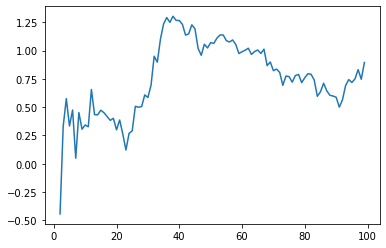

In [125]:
# Optimize parameter of MA timeframe

def trading_strategy(ma:int):
    btc["MA"] = btc.value.rolling(window = ma).mean()
    btc["Chg_btc"] = btc.value.pct_change()
    btc["Position"] = btc.apply(lambda row: positionlabel(row), axis = 1)
    btc["DailyPnL"]= btc["Position"].shift(1)*btc["Chg_btc"]
    btc["cumuPnL"] = btc["DailyPnL"].cumsum()
    btc["dd"] = btc.cumuPnL - btc.cumuPnL.cummax()
    btc["BuyHold"] = btc["Chg_btc"].copy()
    btc.loc[:avg_timeframe,"BuyHold"]=np.nan
    btc["BuyHoldCumu"] = btc.BuyHold.cumsum()
    
    Sharpe = btc.DailyPnL.mean()/btc.DailyPnL.std()*365**0.5
    return Sharpe


param_list = np.arange(2,100,1).tolist() # 100 is reasonable since we only have a 3 year length of data
sharpe_list = [trading_strategy(x) for x in param_list]

plt.plot(param_list,sharpe_list)
print("Given that the Sharpe ratio around interval [30,40] MA timeframe all have good performance in sharpe ratio. There is no issues of overfitting.")
print("Best MA timeframe is", param_list[sharpe_list.index(max(sharpe_list))])
# plt.plot(param_list,trading_strategy(param_list))